# TP 2: Grid Search and Bayesian Inversion on a Synthetic Case of Aquifer-River Exchange

## Preparation 

### Step 1: Download Required Files
Download all required files from this link and extract them to your working directory:
```
https://cloud.minesparis.psl.eu/index.php/s/nt9LJVS4b8Zllww
```

### Step 2: Compile GINETTE
Navigate to the SYNTHETIC_CASES directory and compile the GINETTE executable:
```bash
cd /path/to/ginette/application/2024_TD_ENS/SYNTHETIC_CASES
gfortran -o ginette ../../../src/ginette_V2.f90 
```
### Step 3: Set Up Python Environment
**IMPORTANT:** Modify the path below to match your actual installation directory!

MODIFY THIS PATH TO MATCH YOUR INSTALLATION 
GINETTE_PYTHON_PATH = '/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python'

Add the Python modules path to system path
sys.path.append(GINETTE_PYTHON_PATH)

### Step 4: Initialize GINETTE Directories
GINETTE_WORK_DIR = '/home/ariviere/Programmes/ginette/application/2024_TD_ENS/SYNTHETIC_CASES/'


## Objective

In this lab, we will perform a parameter estimation study using a grid search approach for the heat transfer model in a porous medium under transient conditions. We will:

1. **Generate a reference simulation** that will serve as our "observed data"
2. **Create a grid of parameter combinations** for intrinsic permeability ($k$) and thermal conductivity ($\lambda_s$)
3. **Run forward simulations** for each parameter combination
4. **Compare results** with the reference simulation using statistical metrics
5. **Analyze parameter sensitivity** and identify optimal parameter ranges


## Complete Workflow (Step by Step)

**Step 1:** Create reference simulation (Done!)
- Run model with "true" parameters
- This gives us "perfect" temperature data
- Pretend this is real field measurements

**Step 2:** Generate parameter combinations (To do)
- Create grid of k and λ values
- Each combination = one test case

**Step 3:** Run simulations (To do)  <!-- Removed extra space before "To do" -->
- For each parameter pair:
  - Run the groundwater model
  - Extract temperatures at measurement points
  - Save results

**Step 4:** Compare and score (To do)
- Calculate error metrics (RMSE, MAE)
- Find which parameters give smallest errors

**Step 5:** Analyze and visualize (To do)
- Make plots showing parameter sensitivity
- Understand the physics


## Model Setup

The heat transfer occurs in a portion of a one-dimensional hyporheic zone of 5 meters in height, represented by 250 cells. The hydraulic boundary conditions create a head difference that varies between -0.2 and +0.2 meters (total variation of 0.4m) over time, simulating alternating gaining and losing stream conditions.

## Parameters to Investigate

The grid search will focus on two uncertain parameters:

- **Intrinsic permeability**: $k$ [m²] where $-\log_{10} k \sim \mathcal{U}(11, 15)$ 
- **Thermal conductivity of the solid**: $\lambda_s  [W/m°C] \sim \mathcal{U}(1, 5.5)$ 

We assume these parameters are independent and will systematically vary them to understand their individual and combined effects on temperature predictions.

## Measurement Setup

**Temperature monitoring points** are located along the column at depths:
- 10 cm below surface
- 20 cm below surface  
- 30 cm below surface
- 40 cm below surface

The reference simulation will provide "synthetic observations" at these locations, which will be compared against all grid search simulations to evaluate parameter performance.

## Expected Outcomes

This exercise will help understand:
- **Parameter sensitivity**: Which parameters have the strongest influence on temperature predictions
- **Parameter correlations**: How $k$ and $\lambda_s$ interact to affect model outputs
- **Optimal parameter ranges**: Which combinations best reproduce the reference data
- **Uncertainty quantification**: How parameter uncertainty propagates to model predictions

In [2]:
import sys
import os

# Add the Python modules path to system path so we can import custom functions
# This allows us to use the pre-written functions for GINETTE modeling
sys.path.append('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python')

# Check what files are available in our source directory
# This helps verify that all required modules are present before importing
print("\nFiles in the src_python directory:") 
print(os.listdir('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/'))

# Import all required libraries
# Standard scientific computing libraries
import numpy as np                    # For numerical computations and arrays
from pathlib import Path             # For file path handling
import pandas as pd                  # For data manipulation and analysis
from scipy import interpolate       # For interpolation functions
import matplotlib.pyplot as plt     # For creating plots
import matplotlib as mpl             # For plot customization
from IPython.display import display # For displaying output in notebooks
import subprocess                   # For running external commands
import glob                         # For file pattern matching
import itertools                    # For creating parameter combinations (grid search)
import seaborn as sns               # For advanced statistical plotting
import array                        # For array operations

# Import custom GINETTE-related modules
# These contain pre-written functions specific to our groundwater modeling
from Init_folders import prepare_ginette_directories, compile_ginette
import Direct_model                 # Functions to run the forward model
from Read_obs import process_obs_data  # Functions to read observation data
import Plot                         # Custom plotting functions

# Reload modules to ensure we have the latest version
# This is useful during development when modules might be modified
import importlib
importlib.reload(Direct_model)
importlib.reload(Plot)

# Import specific functions we'll need for this exercise
from Direct_model import setup_ginette, generate_zone_parameters, initial_conditions, boundary_conditions, run_direct_model, remove_first_two_days
from Plot import plot_obs, plot_obs_zoom, plot_compare_temperatures_obs_sim, plot_temperatures_profiles, plot_water_profiles_interpol,plot_temperature_profiles_interpol,plot_fluxes_timeseries,plot_domain,plot_temperatures_sim,plot_heat_flux_profiles_interpolated

# Prepare the directory structure for GINETTE simulations
# This creates all necessary folders and files for the modeling software
prepare_ginette_directories('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/SYNTHETIC_CASES/')


Files in the src_python directory:
['Plot.py', 'Read_obs.py', 'stat_critere.py', '__pycache__', 'Direct_model.py', 'Init_folders.py']
Current working directory: /home/ariviere/Programmes/ginette/application/2024_TD_ENS/SYNTHETIC_CASES
Directory 'SENSI' already exists.
Directory 'OUTPUT' already exists.


## 1. Reference Simulation and Sampling
### 1.1 Setting up a synthetic problem

Now we need to define our modeling domain - this is the physical space where our water and heat transfer simulation will take place.

Now we need to define our modeling domain - this is the physical space where our heat transfer simulation will take place.

**What we're modeling:**
- A **1D vertical column** representing a cross-section through the streambed
- **5 meters deep** - this gives us enough depth to see how surface temperature changes affect deeper layers
- **250 grid cells** with equal spacing (2 cm each) - this gives us good spatial resolution to capture temperature gradients

**Why these choices:**
- **Streambed focus**: The hyporheic zone (where surface water and groundwater interact) is crucial for heat transport
- **5m depth**: At this depth, daily temperature fluctuations at the surface become negligible - we reach the "damping depth"
- **2cm grid spacing**: Fine enough to capture sharp temperature gradients near the surface, but not so fine as to make computations too slow
- **251 grid points**: The first and last points are for boundary conditions (fixed temperatures/heads), so we actually solve temperatures at 249 interior points


**Reference Parameters for Synthetic Case**

These are the "true" parameter values we'll use to generate our synthetic observations. In a real inverse modeling scenario, these would be the unknown parameters we're trying to estimate from field measurements.

| Parameter | Symbol | Value | Units | Physical Meaning |
|-----------|---------|-------|-------|------------------|
| **Intrinsic Permeability (log scale)** | REF_k | -12 | log₁₀(m²) | Controls groundwater flow rate |
| **Thermal Conductivity of Solid** | REF_l | 2.5 | W/m°C | Controls heat conduction in solid matrix |

**Parameter Details:**

1. **Intrinsic Permeability**: `REF_k = -12`
   - Actual permeability: k = 10⁻¹² m² = 1 × 10⁻¹² m²
   - This represents a moderately permeable sediment (fine sand to silt)
   - Controls how easily water flows through the porous medium
   - Higher values → faster groundwater flow → more heat advection

2. **Thermal Conductivity**: `REF_l = 2.5` W/m°C  
   - Thermal conductivity of the solid matrix (quartz-rich sediment)
   - Controls how efficiently heat conducts through the solid grains
   - Higher values → better heat conduction → faster temperature equilibration



In [3]:
# Define the physical domain dimensions
z_top = 0       # Surface level (stream bed) [meters]
z_bottom = -5   # Bottom of our domain [meters] 
az = abs(z_top - z_bottom)  # Total column height = 5 meters
n_depths = 250  # Number of grid cells for discretization

# Calculate grid spacing (discretization)
dz = az / n_depths  # Size of each cell in meters
print('Cell size dz =', dz, 'meters')  # Should be 0.02 m = 2 cm

# Observation spacing for temperature measurements
dz_obs = 0.1    # 10 cm spacing between measurement points [meters]

Cell size dz = 0.02 meters


Next, let's set up the times after initial time $t=0$ at which we'll compute temperatures. We will use a continuous-time, making the assumption of constant discharge and linearly varying boundary temperatures across each time step. Since the discharge and boundary temperatures change over time, the state space model is updated after each time step. So, the time step should be short enough that those assumptions are valid. For this problem setup, we'll use 10 minute time interval, and model 20 days worth of temperatures. The units of all time variables are seconds.

In [4]:
# 10 minute interval
dt = 600 # seconds
# 20 days
nb_day = 30# days
state=1
date_simul_bg=pd.to_datetime("2022/04/21 14:00:00")

z_obs=setup_ginette(dt, state, nb_day, z_top, z_bottom, az, dz, date_simul_bg,dz_obs)


la simulation commence à 2022-04-21 14:00:00


## 1.2 Physical constants

The physical constants used by `Ginette` are $\lambda$ in W/m&deg;C, and $C_s$ in $m^2$ $s^{-2}$ $C^{-1}$, as defined above.

### Intrinsic Permeability [m²]

$$
k = \frac{K \cdot \mu}{\rho \cdot g}
$$

Where:
- $ k $ = intrinsic permeability [m²]
- $ K $ = hydraulic conductivity [m/s]

#### Constant Parameters

- $ \mu $ = viscosity [Pa·s]
- $ \rho $ = density [kg/m³]
- $ g $ = gravitational acceleration [m/s²], approximately \( 9.81 \)

#### Calculation of Intrinsic Permeability
$$
k = 10^{\text{REF}_k}
$$

#### Calculation of the equivalent thermal conductivity

The equivalent thermal conductivity $\lambda_{eq}$ in a porous medium is calculated using a geometric mean approach that accounts for the thermal properties of both the solid matrix and the fluid phases:

$$
\lambda_{eq} = \lambda_s^{(1-n)} \cdot \lambda_w^{n \cdot S_{sat}} \cdot \lambda_a^{n \cdot (1-S_{sat})}
$$

Where:
- $\lambda_{eq}$ = equivalent thermal conductivity of the porous medium [W/m°C]
- $\lambda_s$ = thermal conductivity of the solid matrix [W/m°C]
- $\lambda_w$ = thermal conductivity of water ≈ 0.598 [W/m°C]
- $\lambda_a$ = thermal conductivity of air ≈ 0.025 [W/m°C]
- $n$ = porosity [-]
- $S_{sat}$ = saturation ratio [-]

**For fully saturated conditions** (which is our case), $S_{sat} = 1$, so the equation simplifies to:

$$
\lambda_{eq} = \lambda_s^{(1-n)} \cdot \lambda_w^{n}
$$

**In GINETTE**, we use $\lambda_s$ as our calibration parameter (REF_l), while keeping the other thermal conductivities constant.


### Calculation of Thermal Capacity in Ginette Using the Following Relation:

$$
c_{pm} = c_w \cdot \rho_w \cdot n \cdot sat + c_s \cdot r \cdot (1 - \omega) + c_a \cdot \rho_a \cdot n \cdot (1 - sat)
$$

Where:

- $c_s$ is the specific heat capacity of the solid, with the value $\text{val}_c$ in m²/s²/°C. It is recommended to keep this value constant 1000 (kg/m³) because it is not possible to calibrate both parameters, $\rho$ and $c$, simultaneously.
- $J$ is in units of [kg m² s⁻²]
- $c_w = 4185 \, \text{m}^2/\text{s}^2/°C$
- $\rho_w$ represents density in kg/m³.
- $\rho_s$ is the density of solid grains, $[\text{kg/m}^3]$.



In [5]:
nb_zone=1
alt_thk=0
## Physical constants
# Porosité
REF_n = 0.05 # \omega

#-----------------------------------------------------------------
## Perméabilité intrinsèque [m2]  k=K*mu/(rho*g)
## K Conductivité hydraulique [m.s-1]
## Paramètres constants
### mu Viscosité [Pa.s]
### rho Densité [kg.m-3]
### g Gravité  9.81 [m2.s-1]

# k=10**REF_k
REF_k = -12 # m2
#### constant parameters
mu = 1e-6  # Dynamic viscosity in Pa.s 
rho = 1000  # Density in kg/m^3 
g = 9.81  # Acceleration due to gravity in m/s^2
REF_l = 2.5 # W/m deg C
# Calcul de la capacité thermique dans Ginette par la relation suivante :
#  c_pm = c_w * r_w * n * sat + c_s * r * (1-n) + c_a * r_a * n * (1-sat)
# rho_m imposé : 1000
# c_s Capacité thermique spécifique du solide
# val_c = c_s m2/s2/C. Il est conseillé de laisser cette valeur constante.
# Il n'est pas possible de calibrer les deux paramètres rho et c en même temps.
# J [kg m2 s−2]
# c_w = 4185D+00 m2/s2/C
# r_w = kg m-3itlectur
# Densité des grains solides rho_s = val_r [kg.m-3]
REF_r = 3500

## 1.3 Boundary and initial conditions

In [6]:
# Define the total simulation time in seconds (20 days)
t_final = nb_day * 24 * 60 * 60  # seconds
# Create a DataFrame to store boundary condition data
df_BC = pd.DataFrame()

# Create an array of time points from 0 to t_final with a step of dt
df_BC['times'] = np.arange(0, t_final, dt)
# Pre-calculate constants
seconds_per_day = 60 * 60 * 24
seconds_per_week = 7 * seconds_per_day
# Example of a DataFrame with times and days (assuming df_BC['times'] is already created)
df_BC['days'] = df_BC['times'] / seconds_per_day




#### Hydraulic heads


=== Hydraulic Head Boundary Conditions ===
Top boundary head range: 4.990 to 5.010 m
Total variation: 0.020 m
Bottom boundary head: 5.0 m (constant)
Head difference range: -0.010 to 0.010 m
Column height: 5.0 m
Hydraulic gradient range: -0.0020 to 0.0020 m/m


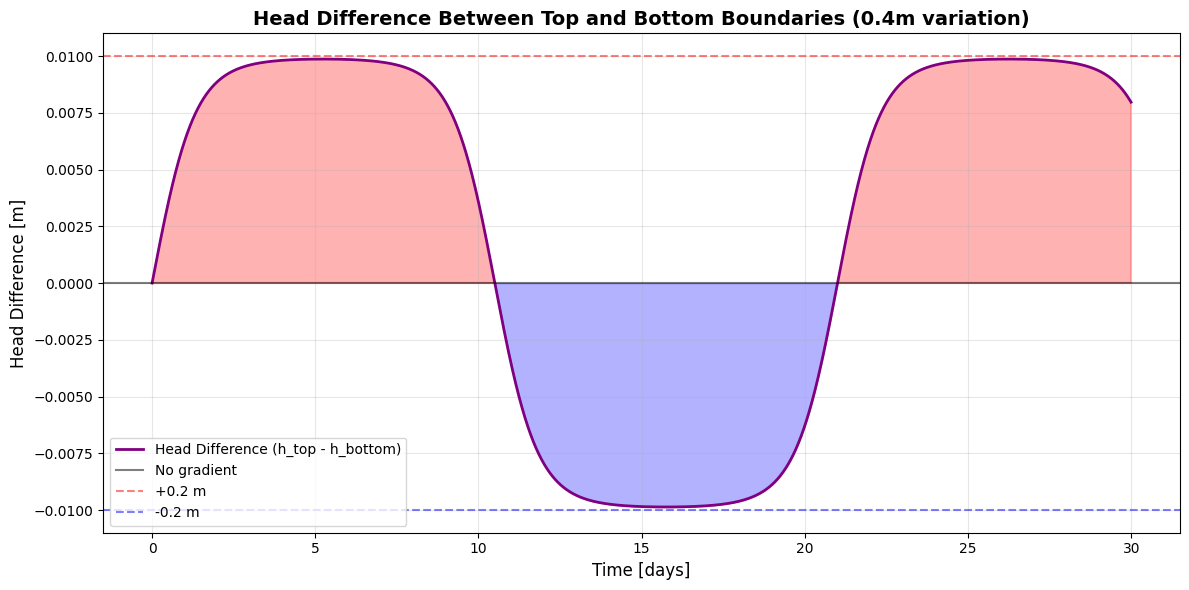


=== Flow Direction Analysis ===
Time with losing conditions (upward flow): 19.5 days (65.0%)
Time with gaining conditions (downward flow): 10.5 days (35.0%)
Time with neutral conditions: 0.0 days (0.1%)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Hydraulic head boundary conditions with increased amplitude
# Pre-calculate constants
two_pi = 2 * np.pi

# Define a smooth square wave function using a sigmoid function
def smooth_square_wave(x, period):
    return 2 / (1 + np.exp(-5 * np.sin(two_pi * x / period))) - 1

# Reduce the frequency by increasing the period
reduced_period = 3 * seconds_per_week  # 3-week period for reduced frequency

# Calculate the top boundary with 0.4m variation (±0.2m around base level)
base_head = 5.0  # Base hydraulic head [m]
head_amplitude = 0.01  # Amplitude for ±0.2m variation (total 0.4m range)

df_BC['h_top'] = (head_amplitude * smooth_square_wave(df_BC['times'], reduced_period)  # ±0.2m variation
                  + base_head)  # Base head level

# Set the bottom boundary to a constant value 
df_BC['h_bottom'] = base_head * np.ones_like(df_BC['times'])

# Calculate the hydraulic gradient for verification
df_BC['head_gradient'] = (df_BC['h_top'] - df_BC['h_bottom']) / az  # Gradient [m/m]

# Print statistics for verification
print("=== Hydraulic Head Boundary Conditions ===")
print(f"Top boundary head range: {df_BC['h_top'].min():.3f} to {df_BC['h_top'].max():.3f} m")
print(f"Total variation: {df_BC['h_top'].max() - df_BC['h_top'].min():.3f} m")
print(f"Bottom boundary head: {df_BC['h_bottom'].iloc[0]:.1f} m (constant)")
print(f"Head difference range: {(df_BC['h_top'] - df_BC['h_bottom']).min():.3f} to {(df_BC['h_top'] - df_BC['h_bottom']).max():.3f} m")
print(f"Column height: {az:.1f} m")
print(f"Hydraulic gradient range: {df_BC['head_gradient'].min():.4f} to {df_BC['head_gradient'].max():.4f} m/m")

# Plot head difference over time (only this plot)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

head_diff = df_BC['h_top'] - df_BC['h_bottom']
ax.plot(df_BC['days'], head_diff, label='Head Difference (h_top - h_bottom)', color='purple', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='No gradient')
ax.axhline(y=0.01, color='red', linestyle='--', alpha=0.5, label='+0.2 m')
ax.axhline(y=-0.01, color='blue', linestyle='--', alpha=0.5, label='-0.2 m')

ax.set_xlabel('Time [days]', fontsize=12)
ax.set_ylabel('Head Difference [m]', fontsize=12)
ax.set_title('Head Difference Between Top and Bottom Boundaries (0.4m variation)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Fill areas to show flow direction
ax.fill_between(df_BC['days'], 0, head_diff, where=(head_diff > 0), 
                alpha=0.3, color='red', label='Losing condition')
ax.fill_between(df_BC['days'], 0, head_diff, where=(head_diff < 0), 
                alpha=0.3, color='blue', label='Gaining condition')

plt.tight_layout()
plt.show()

print("\n=== Flow Direction Analysis ===")
losing_time = np.sum(df_BC['head_gradient'] > 0) * dt / seconds_per_day
gaining_time = np.sum(df_BC['head_gradient'] < 0) * dt / seconds_per_day
neutral_time = np.sum(df_BC['head_gradient'] == 0) * dt / seconds_per_day

print(f"Time with losing conditions (upward flow): {losing_time:.1f} days ({losing_time/nb_day*100:.1f}%)")
print(f"Time with gaining conditions (downward flow): {gaining_time:.1f} days ({gaining_time/nb_day*100:.1f}%)")
print(f"Time with neutral conditions: {neutral_time:.1f} days ({neutral_time/nb_day*100:.1f}%)")

#### Boundary temperatures
Boundary temperatures are needed to solve for temperatures inside the domain. Let's try using a diurnally varying top boundary temperature, and a constant bottom temperature. In addition, we'll give the top boundary a weekly variation, and a slight linear increase over the 20 day time frame.

In [204]:
# Pre-calculate constants
two_pi = 2 * np.pi

# Linear temperature increase over time (0.3 degrees per day)
deg_per_day = 0.3



# Calculate the top boundary temperature
df_BC['T_top'] = (5 * np.sin(two_pi * df_BC['times'] / seconds_per_day)  # Daily fluctuation
                  + deg_per_day * df_BC['days']  # Linear increase per day
                  + 3 * np.sin(two_pi * df_BC['times'] / seconds_per_week)  # Weekly fluctuation
                  + 17)  # Base temperature offset

# Set the bottom boundary temperature to a constant value (10 degrees)
df_BC['T_bottom'] = 10 * np.ones_like(df_BC['times'])

# Display the first few rows to check the results (optional)
print(df_BC.head())


   times      days     h_top  h_bottom  head_gradient      T_top  T_bottom
0      0  0.000000  5.000000       5.0       0.000000  17.000000        10
1    600  0.006944  5.001039       5.0       0.000208  17.238880        10
2   1200  0.013889  5.002078       5.0       0.000416  17.477344        10
3   1800  0.020833  5.003116       5.0       0.000623  17.714978        10
4   2400  0.027778  5.004155       5.0       0.000831  17.951366        10


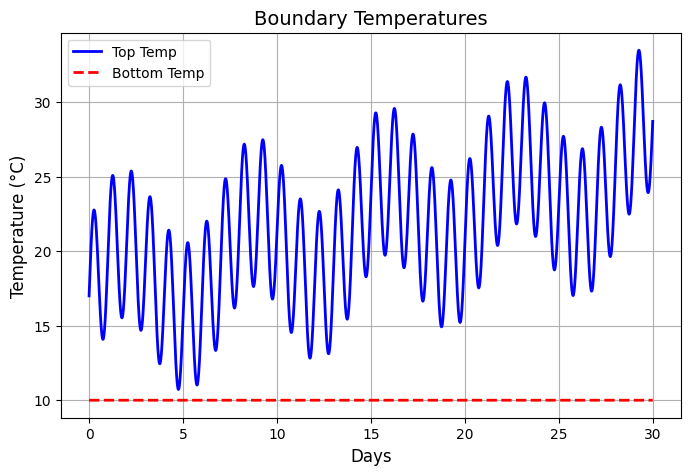

In [205]:
# Plot only the first 1000 points for quicker visualization
plt.figure(figsize=(8, 5))
plt.plot(df_BC['days'], df_BC['T_top'], label='Top Temp', color='b', lw=2)
plt.plot(df_BC['days'], df_BC['T_bottom'], label='Bottom Temp', color='r', ls='--', lw=2)

plt.xlabel('Days', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Boundary Temperatures', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

plt.show()

In [206]:
date_simul_bg=pd.to_datetime("2022/04/21 14:00:00")

# Create the obs_temp DataFrame
obs_temp = pd.DataFrame({
    'dates': date_simul_bg + pd.to_timedelta(df_BC['times'], unit='s'),
    'h_top': df_BC['h_top'],
    'h_bottom': df_BC['h_bottom'],
    'T_top': df_BC['T_top'],
    'T_bottom': df_BC['T_bottom']
})
# Display the obs_temp DataFrame
print(obs_temp)

                   dates     h_top  h_bottom      T_top  T_bottom
0    2022-04-21 14:00:00  5.000000       5.0  17.000000        10
1    2022-04-21 14:10:00  5.001039       5.0  17.238880        10
2    2022-04-21 14:20:00  5.002078       5.0  17.477344        10
3    2022-04-21 14:30:00  5.003116       5.0  17.714978        10
4    2022-04-21 14:40:00  5.004155       5.0  17.951366        10
...                  ...       ...       ...        ...       ...
4315 2022-05-21 13:10:00  5.160674       5.0  27.851551        10
4316 2022-05-21 13:20:00  5.160343       5.0  28.063943        10
4317 2022-05-21 13:30:00  5.160008       5.0  28.277874        10
4318 2022-05-21 13:40:00  5.159671       5.0  28.492933        10
4319 2022-05-21 13:50:00  5.159331       5.0  28.708708        10

[4320 rows x 5 columns]


### 1.3.1 Initial temperatures
An initial state is also required to solve for temperatures at later times. Let's make the simplifying assumption that temperatures vary linearly from top to bottom at time $t=0$.

In [207]:
z_obs=[-5]
initial_conditions(obs_temp, z_top, z_bottom, dz, z_obs)

### 1.3.2 Boundary conditions

In [208]:
boundary_conditions(obs_temp,dt)

'icl_gauche=-1\t\ticl=-1 flux impose sur une face, icl=-2 potentiel impose sur une face ; i2\tc Bord gauche\tC ECOULEMENT\nvalcl_gauche=00000000d+00\tvaleur flux (m/s) valeur charge (m)\t ; d9.0\t\t\t\tc Bord gauche\tC ECOULEMENT\nicl_droite=-1\t\t\t\t\t\t\t\t\t\t \tc Bord droit ; i2\tC ECOULEMENT\nvalcl_droite=00000000d+00\tvaleur flux (m/s) valeur charge (m)\t\t ; d9.0\t\t\tc Bord droit\tC ECOULEMENT\nicl_haut=-2\t\t\t\t\t\t\t\t\t\t\tc Surface ; i2\tC ECOULEMENT\nvalcl_haut=+0005.00d+00\tvaleur flux (m/s) valeur charge (m)\t\t ; d9.0\t\t\tc Surface  \tC ECOULEMENT\nicl_bas=-2\t\t\t\t\t\t\t\t\t\t\tc Base; i2\t\tC ECOULEMENT\nvalcl_bas=+0005.00d+00\tvaleur flux (m/s) valeur charge (m)\t\t\t ; d9.0\t\tc Base\t\tC ECOULEMENT\niclc_gauche=-1\t\t\t\t\t\t\t\t\t\t\tc Bord gauche ; i2\tC TRANSPORT\nvalclc_gauche=00000000d+00\t\t\t\t\t\t\t\t\t\tc Bord gauche  ; d9.0\tC TRANSPORT\niclc_droite=-1\t\t\t\t\t\t\t\t\t\t \tc Bord droit  ; i2\tC TRANSPORT\nvalclc_droite=00000000d+00\t\t\t\t\t\t\t\t\t\

## 1.4 run simulation

In [209]:
sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, REF_l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 

 simu done


## 1.5 Plot the results

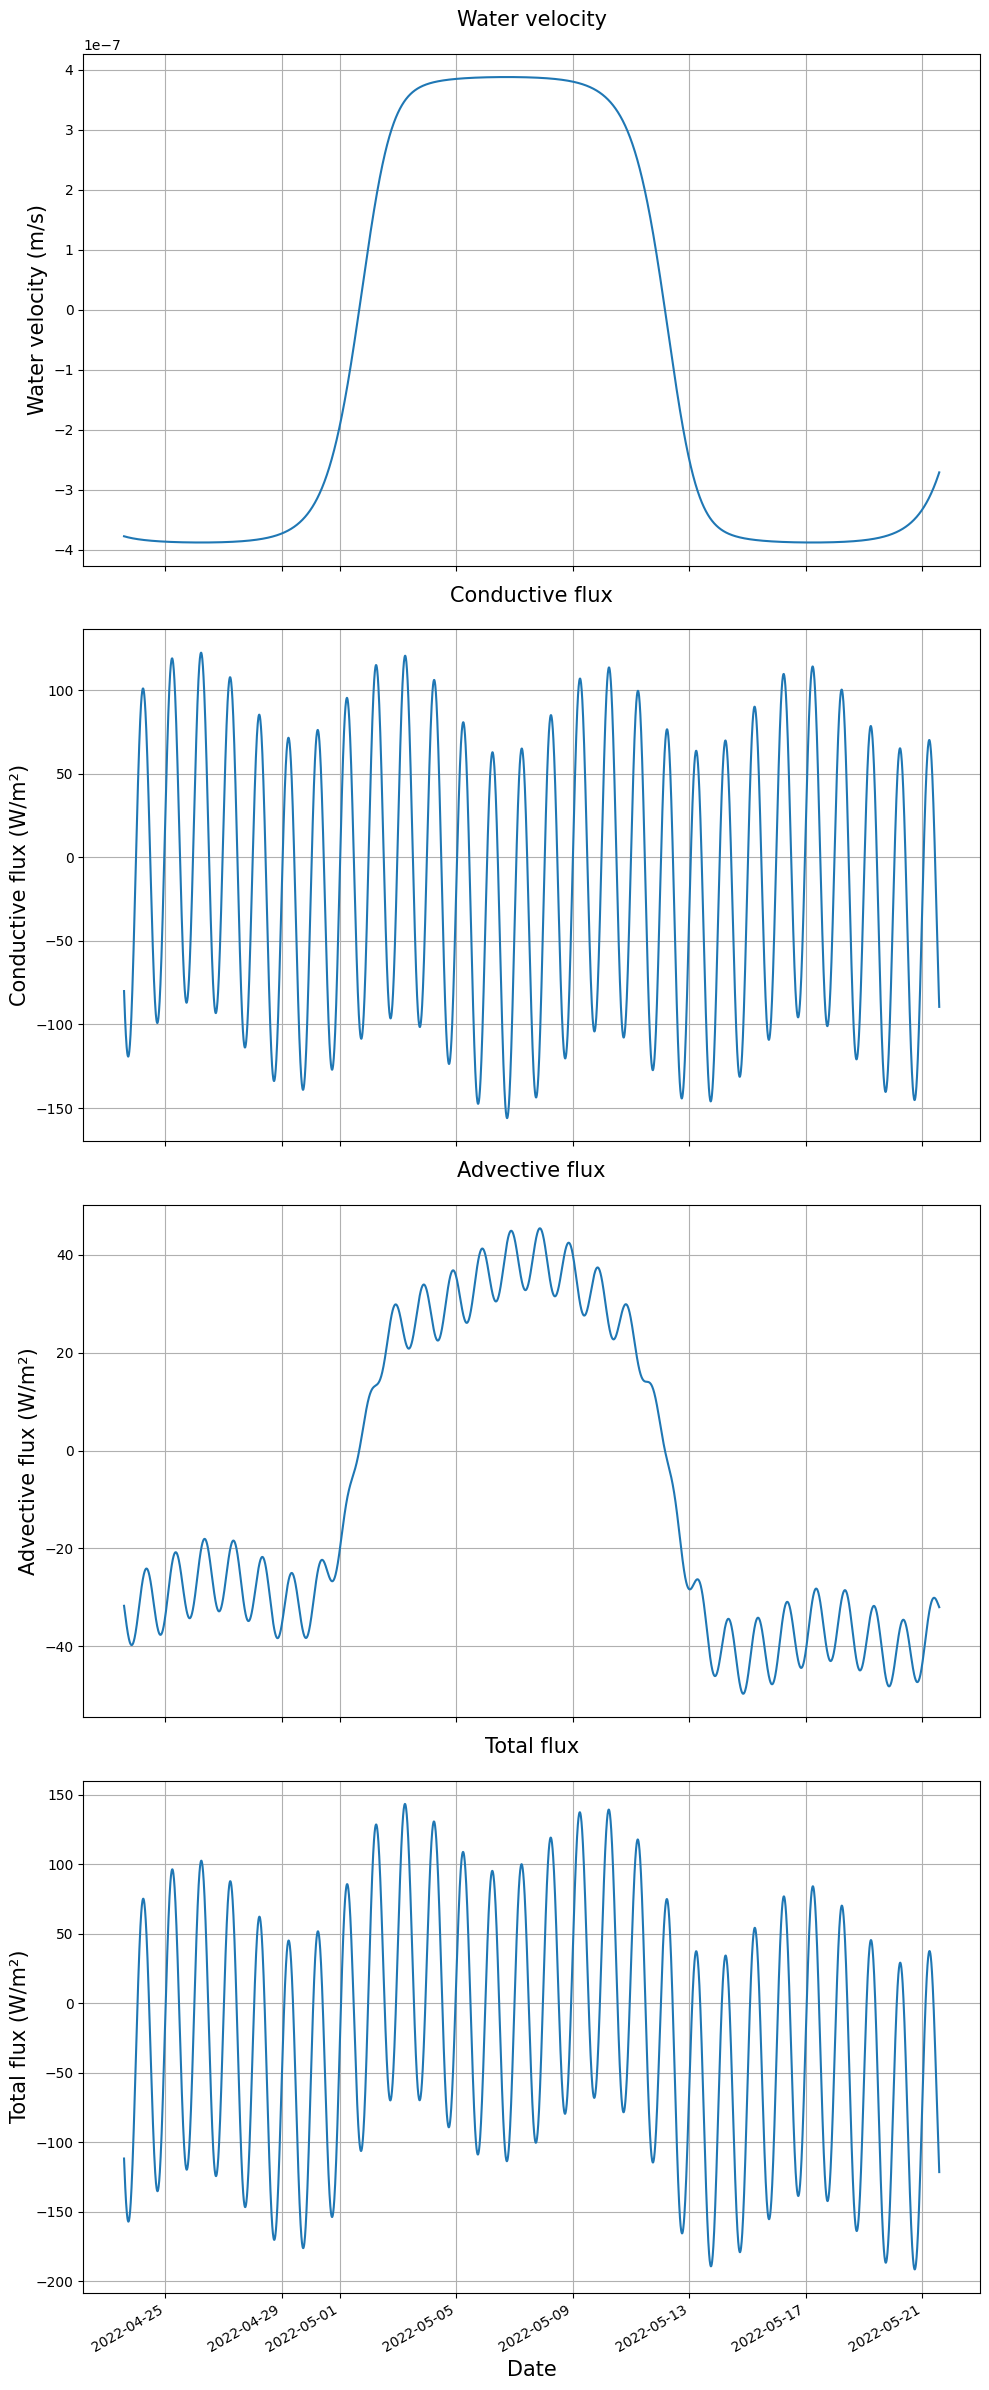

In [210]:
plot_fluxes_timeseries(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

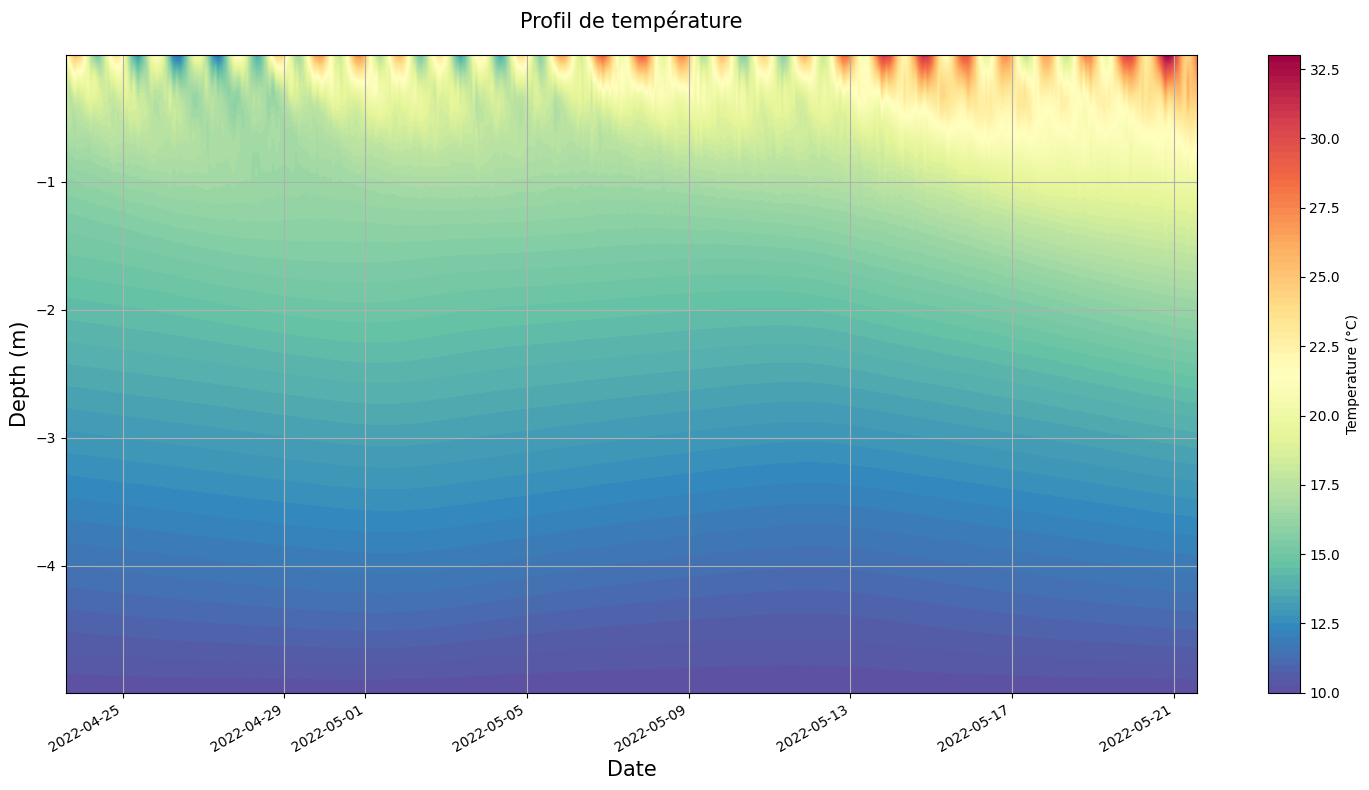

In [211]:
plot_temperature_profiles_interpol(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

In [212]:
sim_temp

,Time,Temp1,Temp2,Temp3,dates
0,600.0,16.867219,16.727273,16.587413,2022-04-21 14:10:00
1,1200.0,16.871147,16.727912,16.587866,2022-04-21 14:20:00
2,1800.0,16.881392,16.728842,16.588518,2022-04-21 14:30:00
3,2400.0,16.899913,16.730117,16.589271,2022-04-21 14:40:00
4,3000.0,16.927520,16.731932,16.590095,2022-04-21 14:50:00
...,...,...,...,...,...
4315,2589600.0,25.776154,25.240686,24.880227,2022-05-21 13:20:00
4316,2590200.0,25.854387,25.246020,24.868589,2022-05-21 13:30:00
4317,2590800.0,25.936197,25.253728,24.857824,2022-05-21 13:40:00
4318,2591400.0,26.021432,25.263803,24.847962,2022-05-21 13:50:00


## 1.6 Plot the simulated temperatures.
These temperature will be used as the observed data

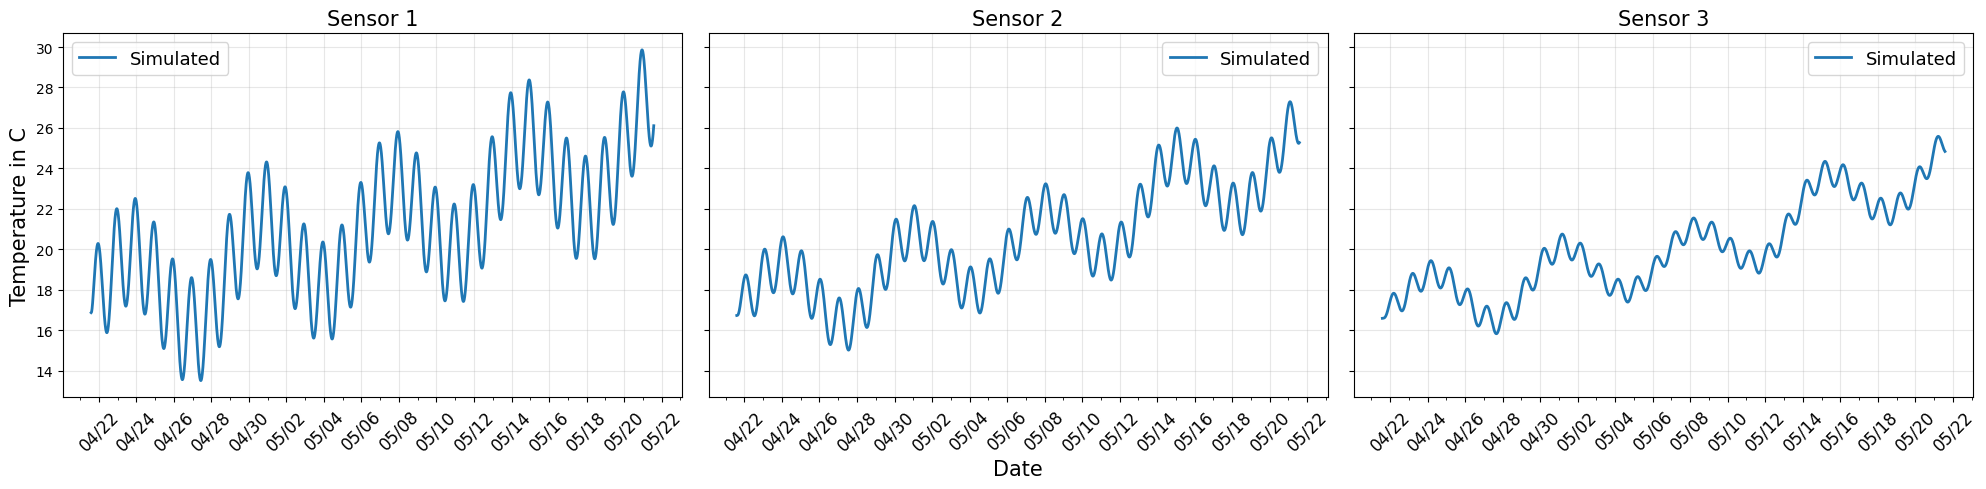

In [213]:
plot_temperatures_sim(sim_temp, fontsize=15)

# 1.7 Save the Reference Simulation Results

**IMPORTANT:** This step is crucial for our grid search analysis!

The temperature data we just generated (`sim_temp`) represents our "perfect" reference case. In a real-world scenario, this would be your actual field measurements from temperature sensors.

**What we need to do:**
1. **Extract temperatures** at our 4 measurement depths (10, 20, 30, 40 cm)
2. **Save this data** as our "observed" temperature dataset
3. **Use this reference** to compare against all parameter combinations in our grid search

**Why save it separately:**
- We'll run many simulations with different k and λ values
- Each simulation will be compared against these reference temperatures
- This allows us to find which parameter combinations best reproduce our "observations"

 Think of this as creating your synthetic field data that you'll try to match with your models!

In [214]:
# Save the reference simulation temperatures as our "observed data"
# This is what we'll try to match with different parameter combinations

# Extract temperature data at our observation depths (10, 20, 30, 40 cm)
# sim_temp contains temperatures at all depths and times
observed_temperatures = sim_temp.copy()  # Make a copy to preserve the original

print("Reference simulation saved as 'observed_temperatures'")
print(f"Data shape: {observed_temperatures.shape}")
print(f"Time range: {len(observed_temperatures)} time steps")
print("\nThis data will be used as the target for our parameter estimation!")

Reference simulation saved as 'observed_temperatures'
Data shape: (4320, 4)
Time range: 4320 time steps

This data will be used as the target for our parameter estimation!


# 2. Generate a table of parameters 

In [215]:
# Section 2: Generate parameter grid
# Create combinations of k and lambda values to test

# Define parameter ranges
k_values = np.logspace(-15, -11, 20)  # Intrinsic permeability range
lambda_values = np.linspace(1, 8, 15)  # Thermal conductivity range

# Create all combinations
param_combinations = list(itertools.product(k_values, lambda_values))
print(f"Testing {len(param_combinations)} parameter combinations")

# Create DataFrame to store results
results_df = pd.DataFrame(param_combinations, columns=['k_value', 'lambda_value'])
results_df['simulation_id'] = range(len(param_combinations))

Testing 300 parameter combinations


# 3. Run Simulations for Each Parameter Combination

## Your Task:
Write code to run the forward model for each parameter combination in your grid.

### Hints:
- Use a `for` loop to iterate through `param_combinations`
- For each pair `(k_val, lambda_val)`, convert to REF format: `REF_k = np.log10(k_val)`
- Call `run_direct_model()` with the new parameter values
- Store results in a list or DataFrame
- Calculate error metrics (RMSE, MAE) compared to `observed_temperatures`

### Expected outcome:
A DataFrame containing all parameter combinations and their performance metrics.

**Start coding below:**

# 4. Statistical Analysis

## Your Task:
Analyze which parameter combinations work best.

### Questions to answer with code:
1. Which parameter combination gives the lowest RMSE?
2. How do the best-fit parameters compare to the true values?
3. What's the range of RMSE values across all combinations?

**Start coding below:**


# 5. Parameter Sensitivity Analysis and Visualization 


1. **Create visualizations** to show how parameters affect model performance

2. **Analyze parameter sensitivity**
   - Which parameter (k or λ) has stronger influence ?

3. **Interpret the results**
   - What do the patterns tell you about the physics?
   - How does parameter uncertainty affect temperature predictions?

**Start coding below:**
